# Imports

In [1]:
!pwd
import sys
sys.path.append("..")
from bumps.names import Curve, fit, FitProblem
from bumps.dream.state import load_state
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import os
import math

from molgroups.support import molstat
from molgroups import mol
from molgroups import lipids


/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/diffraction/NagleDOPC_2methylsigma/fit_accounting_for_missing_oxygen_in_model


# Variables

In [2]:
ed2sld = 2.814e-5
# bulk sld used during form factor calculation from experimental data
bulksld_ffc = 0.333 * ed2sld

maxarea = 100
stepsize = 0.1
#make sure dimension is odd
dimension = 2000
startz = 50

store = "T4"
setupdir = os.getcwd()
runfile = "run"
fitsource = "bumps"

if not os.path.isdir(store):
    os.mkdir(store)

run = False
burn = 5000
steps = 50

# Functions

In [3]:
def getSLD(aArea, aSL, normArea, bulksld):
    aSLD = np.zeros(dimension).tolist()
    
    # bulksld_ffc can be replaced by bulksld if it is assumed that during form factor calculation
    # the correct subtraction was applied
    
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i] * stepsize) * aArea[i] / normArea + bulksld_ffc * (1 - aArea[i] / normArea)
        else:
            aSLD[i] = bulksld_ffc
    return aSLD


In [4]:
def symmetrize(aSLD, bulksld):
    center = bilayer.fnGetCenter()
    center = int(center/stepsize+0.5)
    canvas_center = len(aSLD) // 2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1]) * 0.5
    symmetrized_bilayer -= bulksld
    return symmetrized_bilayer


In [5]:
def computeFormFactor(lq, aSLD, prefactor, dq, offset, stepsize, DCTtype=1):

    half_bilayer = aSLD[int(len(aSLD)/2) :]

    # TODO: Make sure that lq and x are roughly comparable
    # dimension should be odd
    dct_dimension = 5001
    
    # DCT is unnormalized, except for stepsize, which ensures that FO obeys the integral norm
    F = fft.dct(half_bilayer, n=dct_dimension, type=DCTtype) * stepsize
    F = np.abs(F)
    # normalization by integral of FF
    #sum = F.sum() * np.pi / (2 * dct_dimension * stepsize) * (2 * 1) * dq
    #if sum != 0:
    #    F /= sum
    x = np.array(
        [
            np.pi / (2 * dct_dimension * stepsize) * (2 * i) * dq
            for i in range(dct_dimension)
        ]
    )

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, period=None) * prefactor - offset


In [6]:
def setBilayer(
    l_lipid, va1, vm1, l_choline, v_choline, l_cg, v_cg, l_phosphate, v_phosphate, sigma, rel_pos, hg1_thickness, methyl_sigma, methyl_sigma2, nf_methyl2, bulksld):
    bilayer.methylene1_1.vol=va1-vm1
    bilayer.methylene1_2.vol=va1-vm1
    bilayer.methylene2_1.vol=va1-vm1
    bilayer.methylene2_2.vol=va1-vm1
    bilayer.methyl1_1.vol=vm1
    bilayer.methyl1_2.vol=vm1
    bilayer.methyl2_1.vol=vm1
    bilayer.methyl2_2.vol=vm1

    bilayer.headgroups1[0].choline.nsl = bilayer.headgroups2[0].choline.nsl = 1.407e-3
    bilayer.headgroups1[0].phosphate.nsl = bilayer.headgroups2[0].phosphate.nsl = 1.323e-3
    bilayer.headgroups1[0].carbonyl_glycerol.nsl = bilayer.headgroups2[0].carbonyl_glycerol.nsl \
        = 1.885e-3 - (8*0.00002814) # one O is missing
    
    bilayer.headgroups1[0].choline.vol = bilayer.headgroups2[0].choline.vol = v_choline #108.6 # was 120
    bilayer.headgroups1[0].phosphate.vol = bilayer.headgroups2[0].phosphate.vol = v_phosphate #54
    bilayer.headgroups1[0].carbonyl_glycerol.vol = bilayer.headgroups2[0].carbonyl_glycerol.vol = v_cg # 156.2-15 # was 147

    bilayer.headgroups1[0].choline.l = bilayer.headgroups2[0].choline.l = l_choline
    bilayer.headgroups1[0].phosphate.l = bilayer.headgroups2[0].phosphate.l = l_phosphate
    bilayer.headgroups1[0].carbonyl_glycerol.l = bilayer.headgroups2[0].carbonyl_glycerol.l = l_cg

    bilayer.headgroups1[0].fnSet(length=hg1_thickness, rel_pos=[0, rel_pos, 0])
    bilayer.headgroups1[0].fnSetSigma(sigma)
    bilayer.headgroups2[0].fnSet(length=hg1_thickness, rel_pos=[0, rel_pos, 0])
    bilayer.headgroups2[0].fnSetSigma(sigma)

    bilayer.methyl_sigma[0] = methyl_sigma
    
    bilayer.headgroups1[1].choline.nsl = bilayer.headgroups2[1].choline.nsl = 1.407e-3
    bilayer.headgroups1[1].phosphate.nsl = bilayer.headgroups2[1].phosphate.nsl = 1.323e-3
    bilayer.headgroups1[1].carbonyl_glycerol.nsl = bilayer.headgroups2[1].carbonyl_glycerol.nsl \
        = 1.885e-3 - (8*0.00002814) # one O is missing

    bilayer.headgroups1[1].choline.vol = bilayer.headgroups2[1].choline.vol = v_choline #108.6 # was 120
    bilayer.headgroups1[1].phosphate.vol = bilayer.headgroups2[1].phosphate.vol = v_phosphate #54
    bilayer.headgroups1[1].carbonyl_glycerol.vol = bilayer.headgroups2[1].carbonyl_glycerol.vol = v_cg # 156.2-15 # was 147

    bilayer.headgroups1[1].choline.l = bilayer.headgroups2[1].choline.l = l_choline
    bilayer.headgroups1[1].phosphate.l = bilayer.headgroups2[1].phosphate.l = l_phosphate
    bilayer.headgroups1[1].carbonyl_glycerol.l = bilayer.headgroups2[1].carbonyl_glycerol.l = l_cg

    bilayer.headgroups1[1].fnSet(length=hg1_thickness, rel_pos=[0, rel_pos, 0])
    bilayer.headgroups1[1].fnSetSigma(sigma)
    bilayer.headgroups2[1].fnSet(length=hg1_thickness, rel_pos=[0, rel_pos, 0])
    bilayer.headgroups2[1].fnSetSigma(sigma)

    bilayer.methyl_sigma[1] = methyl_sigma2
    
    bilayer.inner_lipid_nf = np.array([1-nf_methyl2, nf_methyl2])
    bilayer.outer_lipid_nf = np.array([1-nf_methyl2, nf_methyl2])

    bilayer.fnSet(sigma, bulksld, startz, l_lipid, l_lipid, vf_bilayer=1)


In [7]:
def modelformfactor(
    lq,
    l_lipid,
    va1,
    vm1,
    l_choline,
    v_choline,
    l_cg,
    v_cg,
    l_phosphate,
    v_phosphate,
    sigma,
#    prefactor,
#    dq,
#    offset,
    rel_pos,
    hg1_thickness,
    methyl_sigma,
    methyl_sigma2,
    nf_methyl2,
    bulksld
):
    setBilayer(
        l_lipid,
        va1,
        vm1,
        l_choline,
        v_choline,
        l_cg,
        v_cg,
        l_phosphate,
        v_phosphate,
        sigma,
        rel_pos,
        hg1_thickness,
        methyl_sigma,
        methyl_sigma2,
        nf_methyl2,
        bulksld
    )
    
    #set all unused parameters
    dq=1.0
    prefactor = 1.0
    offset=0.
    
    z = np.linspace(0, dimension * stepsize, dimension, endpoint=False)
    normArea, aArea, aSL = bilayer.fnWriteProfile(z)
    aSLD = getSLD(aArea, aSL, normArea, bulksld)
    aSLD = symmetrize(aSLD, bulksld)
    modelform = computeFormFactor(lq, aSLD/ed2sld, prefactor, dq, offset, stepsize)
    
    # save a bunch of parameters when restoring problem states
    problem.bilayers = [bilayer]
    problem.stepsize = stepsize
    problem.dimension = dimension
    problem.sld = aSLD
    problem.moldat = bilayer.fnWritePar2Dict({}, 'bilayer', z)
   
    return modelform


# Fit Setup

In [8]:
F2 = np.loadtxt("xff.dat")
F2 = F2[np.argsort(F2[:, 0])]
q_exp = F2[:, 0]
form_exp = F2[:, 1]
# constant error bar estimate of .05 Å
dform_exp = [0.01] * len(form_exp)


Set scattering lengths, volumes, lengths
| abb | name |
| :- | :- |
|va1 |Volume acyl chains, lipid 1|
|na1 |SL acyl chains, lipid 1|
|vm1 |Volume methyl groups, lipid 1|
|nm1 |SL methyl groups, lipid 1|
|vh1 |Headgroup volume, lipid 1|
|nh1 |SL headgroup, lipid 1|
|lh1 |Length headgroup, lipid 1|
|va2 |Volume acyl chains, lipid 2|
|na2 |SL acyl chains, lipid 2|
|vm2 |Volume methyl groups, lipid 2|
|nm2 |SL methyl groups, lipid 2|
|vh2 |Headgroup volume, lipid 2|
|nh2 |SL headgroup, lipid 2|
|lh2 |Length headgroup, lipid 2|
|va3 |Volume acyl chains, lipid 3|
|na3 |SL acyl chains, lipid 3|
|vm3 |Volume methyl groups, lipid 3|
|nm3 |SL methyl groups, lipid 3|
|vh3 |Headgroup volume, lipid 3|
|nh3 |SL headgroup, lipid 3|
|lh3 |Length headgroup, lipid 3|
|vc  |volume cholesterol|
|nc  |SL cholesterol|


In [9]:
bilayer = mol.BLM(lipids=[lipids.DOPC, lipids.DOPC], lipid_nf=[0.5, 0.5], xray_wavelength=1.514)

In [10]:
l_lipid_initial = 11
va1_initial=985.6
vm1_initial=100.4
l_choline_initial = 6.34
v_choline_initial = 120
l_cg_initial = 4.21
v_cg_initial = 147
l_phosphate_initial = 3.86
v_phosphate_initial = 54
sigma_initial = 2.0
bulksld_initial = 9.4114e-06
prefactor_initial = 1
dq_initial = 1
offset_initial = 0
rel_pos_initial = 0.5
methyl_sigma_initial = 0.1
methyl_sigma2_initial = 0.2
nf_methyl2_initial = 0.5
lh1 = 9.65

In [11]:
M2 = Curve(
    modelformfactor,
    q_exp,
    form_exp,
    dform_exp,
    l_lipid=l_lipid_initial,
    va1=va1_initial,
    vm1=vm1_initial,
    l_choline=l_choline_initial,
    v_choline=v_choline_initial,
    l_cg=l_cg_initial,
    v_cg=v_cg_initial,
    l_phosphate=l_phosphate_initial,
    v_phosphate=v_phosphate_initial,
    sigma=sigma_initial,
#    prefactor=prefactor_initial,
#    dq=dq_initial,
#    offset=offset_initial,
    rel_pos=rel_pos_initial,
    hg1_thickness=lh1,
    methyl_sigma=methyl_sigma_initial,
    methyl_sigma2=methyl_sigma2_initial,
    nf_methyl2=nf_methyl2_initial,
    bulksld=bulksld_initial
)


In [12]:
M2.l_lipid.range(9, 13)
M2.va1.range(950, 1005)
M2.vm1.range(90, 110)
M2.l_choline.range(2, 7.5)
M2.v_choline.range(100., 140.)
M2.l_cg.range(1, 7)
M2.v_cg.range(130., 170.)
M2.l_phosphate.range(0.1, 7)
M2.v_phosphate.range(40., 80.)
M2.sigma.range(1.0, 4.0)
#M2.prefactor.range(0.5, 1.5)
#M2.dq.range(0.95, 1.1)
#M2.offset.range(-0.1, 0.1)
M2.hg1_thickness.range(7, 12)
M2.rel_pos.range(0, 1)
M2.methyl_sigma.range(1, 3)
M2.methyl_sigma2.range(2, 10)
M2.nf_methyl2.range(0.1, 0.3)
M2.bulksld.range(9.35e-6, 9.42e-6)


Parameter(bulksld)

# Run the fit

In [13]:
model = M2
problem = FitProblem(model)


In [14]:
from bumps.mapper import MPMapper

mapper = MPMapper.start_mapper(problem, None, cpus=0)  # cpus=0 for all CPUs
if run:
    result = fit(
        problem,
        method="dream",
        mapper = mapper,
        samples=10,
        burn=burn,
        steps=steps,
        thin=1,
        alpha=0,
        outliers="none",
        trim="none",
        verbose=True,
    )
    res_state = result.state
    res_state.save(store + "/" + runfile)  # save chains
    problem.fitness.save(store + "/" + runfile)  # save fit plot data

else:
    print(os.getcwd() + "/" + store + "/" + runfile)
    res_state = load_state(os.getcwd() + "/" + store + "/" + runfile)
    res_state.mark_outliers()


/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/diffraction/NagleDOPC_2methylsigma/fit_accounting_for_missing_oxygen_in_model/T4/run


# Analyze Fit
## Best Fit Profiles

1.6216529859390918


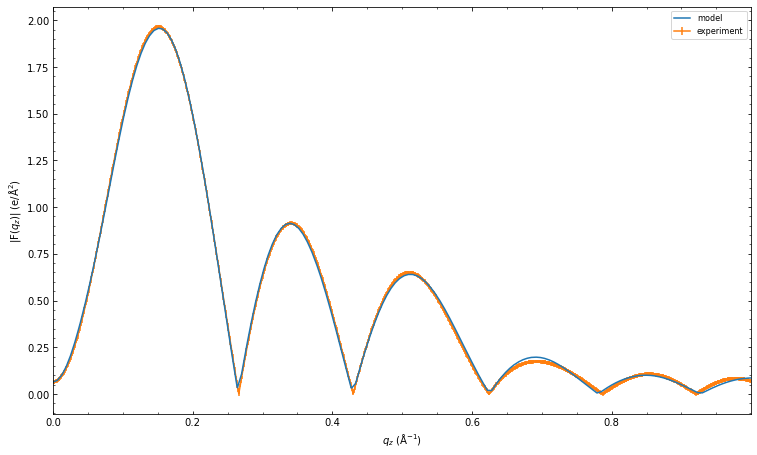

In [15]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq())

q, F, dq, Fy = np.loadtxt(store + "/" + runfile + ".dat", skiprows=1).T

# This creates the q-vector to generate an output to zero and plots the theory in this range
if q[0] > 0:
    qmaxtheo = math.floor(q[0]/(q[1]-q[0]))*(q[1]-q[0])
    if qmaxtheo == q[0]:
        qmaxtheo -= stepsize
    if qmaxtheo <= 0:
        qmaxtheo = 0

    q_theo = np.linspace(0, qmaxtheo, num=int(qmaxtheo/(q[1]-q[0])))
    q_theo = np.concatenate([q_theo, q])
else:
    q_theo = q
F_theo = M2.theory(q_theo)


fig, ax = plt.subplots()
# ax.plot(q, Fy, zorder=2, label="model")
# ax.plot(q_theo, F_theo, zorder=2, label="model")
ax.plot(q_theo, F_theo, zorder=2, label="model")
ax.errorbar(q, F, dq, zorder=1, label="experiment")
ax.legend(fontsize=8)
ax.set_xlim([0, q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
fig.patch.set_facecolor('white')
plt.savefig(store + "/model.png", facecolor="white")
plt.show()


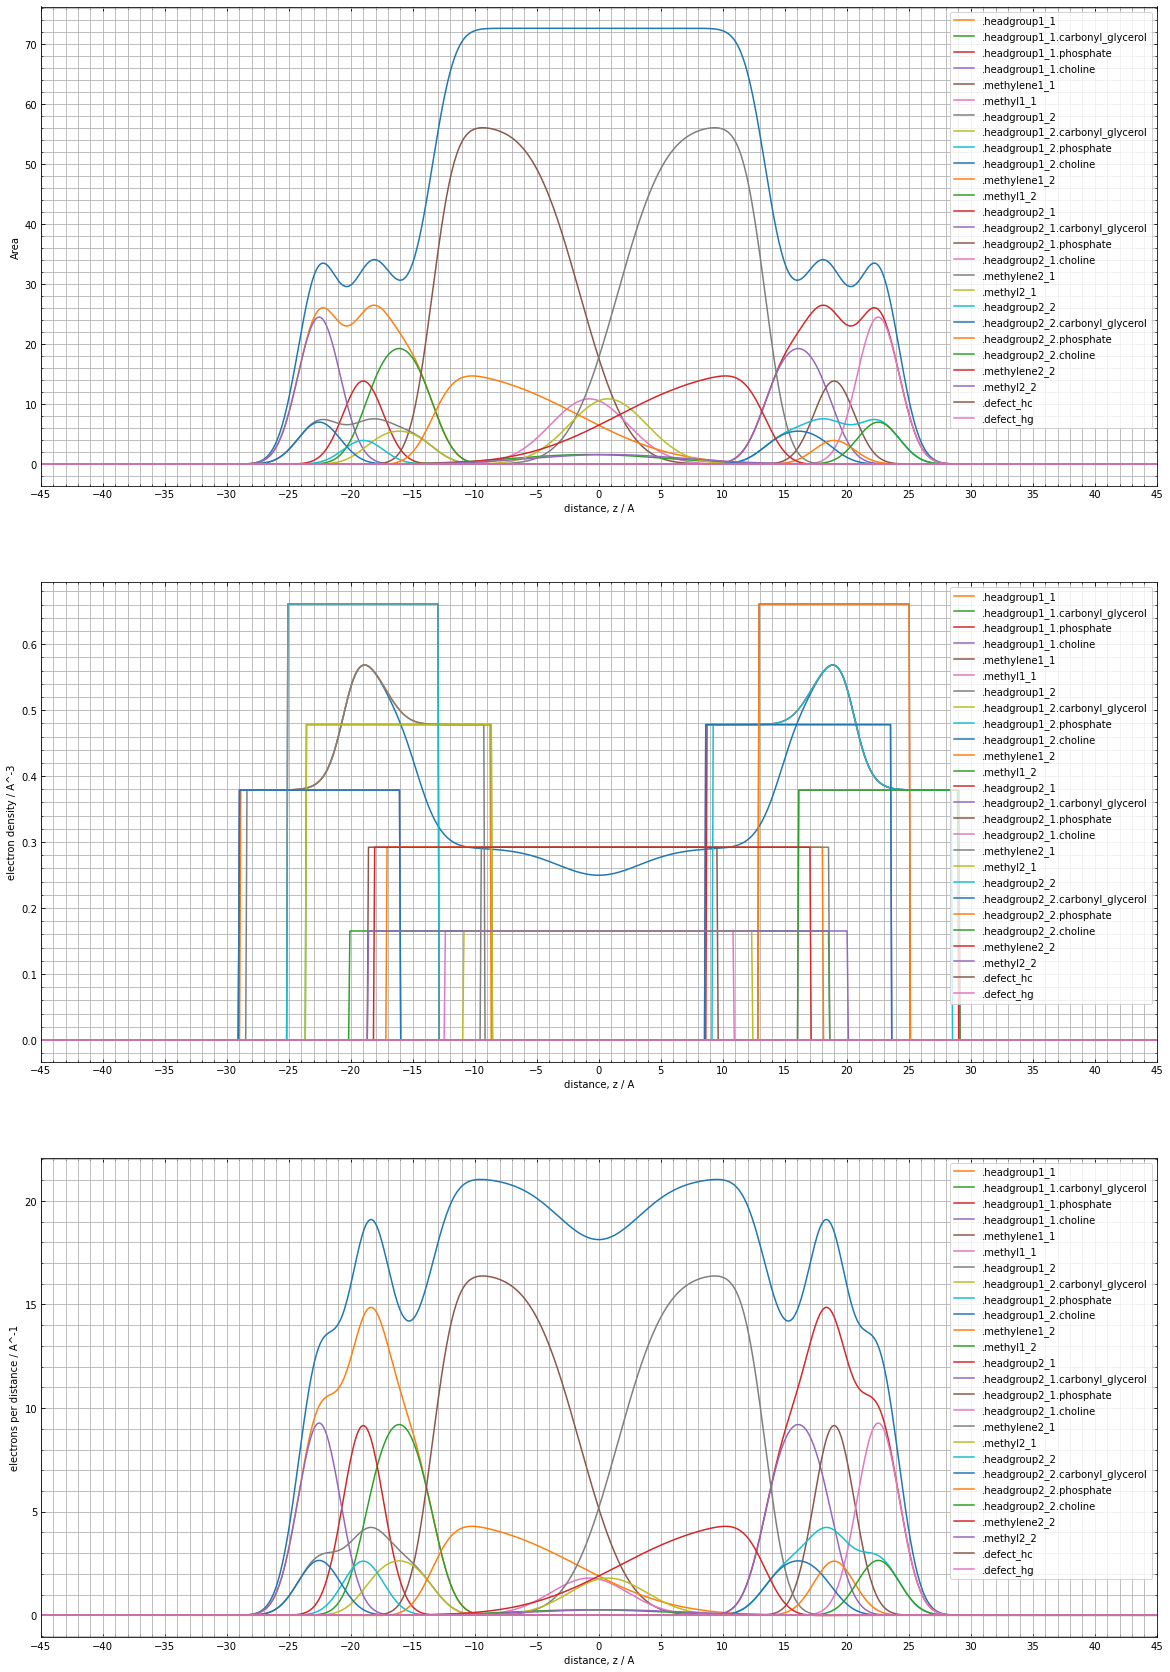

In [16]:
def plot_components(z, blm, center):
    def _add_components(obj, name, nf, center):
        for key, val in obj.__dict__.items():       # cycle over all attributes of blm
            if isinstance(val, mol.nSLDObj):        # if instance of nSLDObj, plot its profile
                ddp, aArea, anSL = val.fnWriteProfile(z)
                aArea = np.array(aArea)
                anSL = np.array(anSL)
                # sel = aArea>0
                anSLD = np.divide(anSL, aArea, out=np.zeros_like(anSL), where=aArea>0.01)
                anSLD /= stepsize
                # anSLD = anSL[sel] / (aArea[sel] * stepsize)
                ax[0].plot(z-center, aArea*nf, '-', label=name+'.'+val.name)
                ax[1].plot(z-center, anSLD/ed2sld, '-', label=name+'.'+val.name)
                ax[2].plot(z-center, anSL*nf/ed2sld/stepsize, '-', label=name+'.'+val.name)
                _add_components(val, name+'.'+val.name, nf*val.nf, center)

    dd, aArea, anSL = blm.fnWriteProfile(z)
    aArea = np.array(aArea)
    anSL = np.array(anSL)
    #sel = aArea>0
    anSLD = np.divide(anSL, aArea, out=np.zeros_like(anSL), where=aArea>0.01)
    anSLD /= stepsize
    #anSLD = anSL / (aArea * stepsize)

    fig, ax = plt.subplots(3, 1, figsize=(20,30))
    fig.patch.set_facecolor('white')
    ax[0].plot(z-center, aArea)
    ax[1].plot(z-center, anSLD/ed2sld)
    ax[2].plot(z-center, anSL/ed2sld/stepsize)
    ax[0].set_ylabel('Area')
    ax[1].set_ylabel('electron density / A^-3')
    ax[2].set_ylabel('electrons per distance / A^-1')
    ax[0].set_xlabel('distance, z / A')
    ax[1].set_xlabel('distance, z / A')
    ax[2].set_xlabel('distance, z / A')

    # plot individual components
    _add_components(bilayer, "", 1., center)

    for i in range(3):
        ax[i].legend(loc=0)
        ax[i].legend(loc="upper right")
        ax[i].minorticks_on()
        ax[i].tick_params(which="both", direction="in", labelsize=10)
        ax[i].tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax[i].set_xlim(-45, 45)
        ax[i].set_xticks(np.arange(-45, 46, 5.0))
        ax[i].grid(True, which='Both')
    fig.patch.set_facecolor('white')
    plt.savefig(store + "/best", facecolor="white")
    plt.show()

bilayer = problem.bilayers[0]
# center around methyl distribution
center = bilayer.methyl1_1.z + 0.5 * bilayer.methyl1_1.l
z = np.arange(dimension) * stepsize
bilayer.fnAdjustParameters()
plot_components(z, bilayer, center)

## Statistical Analysis

In [17]:
from bumps.dream.stats import var_stats, save_vars

print("final chisq", problem.chisq_str())
draw = res_state.draw(portion=1)
all_vstats = var_stats(draw)
save_vars(all_vstats, store + "/" + runfile + ".json")


final chisq 1.622(18)


/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/bumps/dream/varplot.py:240: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolormesh(x, y, z, vmin=vmin, vmax=vmax, cmap=cmap)
/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/bumps/dream/varplot.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers, height, maxlikelihood = array(bins).T
/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/bumps/dream/varplot.py:240: MatplotlibDeprecatio

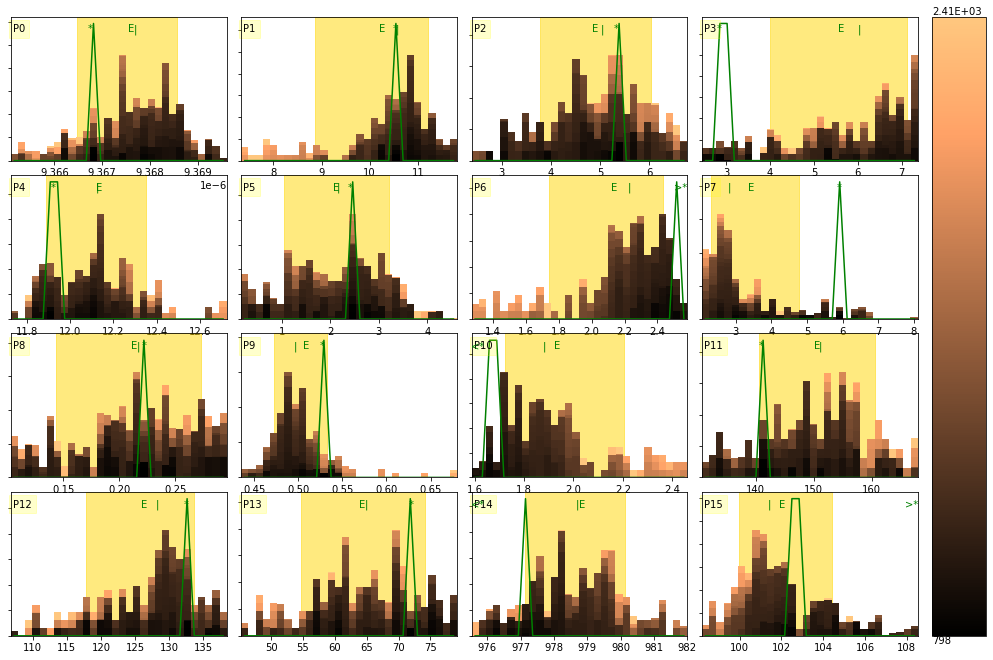

In [18]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig

err = sys.stderr
sys.stderr = open("/dev/stderr", "w")
figure(figsize=varplot.var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0] // 10000, 400), 30)
varplot.plot_vars(draw, all_vstats, nbins=nbins)
if run:
    savefig(store + "/var", facecolor="white")
else:
    savefig(store + "/var_reloaded", facecolor="white")
sys.stderr = err


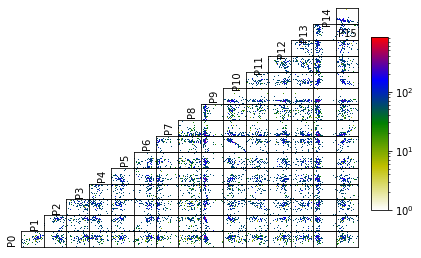

In [19]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()
if run:
    savefig(store + "/corr", facecolor="white")
else:
    savefig(store + "/corr_reloaded", facecolor="white")


In [20]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq())


1.6216529859390918


In [21]:
import os


if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_analysis = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=res_state,
    problem=problem,
)


In [22]:
sparse = 0.005
fit_analysis.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)


No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Analysis of current MC simulation ...
Number of iterations: 40
      bulksld  [  |+       ]  [  9.35e-06,  9.42e-06]  [ 9.366e-06(0.000),  9.368e-06(0.001),  9.369e-06(0.000)] (- 1.858e-09, + 8.707e-10)
hg1_thickness  [  |    -|  ]  [         7,        12]  [     8.072(0.010),      10.43(0.005),       10.9(0.001)] (-     2.357, +    0.4675)
         l_cg  [     | - | ]  [         1,         7]  [     4.054(0.018),      5.259(0.001),      6.109(0.003)] (-     1.205, +    0.8503)
    l_choline  [   |  -  | ]  [         2,       7.5]  [     3.471(0.000),      5.278(0.027),       7.17(0.007)] (-     1.807, +     1.892)
      l_lipid  [       |+  ]  [         9,        13]  [     11.91(0.000),      12.13(0.001),      12.35(0.000)] (-    0.2251, +    0.2134)
  l_phosphate  [  |- |     ]  [       0.1,         7]  [     1.352(0.006),       2.37(0.008),      3.334(0.003)] (-     1.018, +     0.964)
 methyl_sigma  [ 

In [23]:
fit_analysis.fnCreateBilayerPlotData()

Initializing ...
Pulling all molgroups ...
  substrate ...
Molecular group bilayer.substrate does not exist.
  siox ...
Molecular group bilayer.siox does not exist.
  tether ...
Molecular group bilayer.bME does not exist.
Molecular group bilayer.tetherg does not exist.
Molecular group bilayer.tether does not exist.
Molecular group bilayer.tether_bme does not exist.
Molecular group bilayer.tether_free does not exist.
Molecular group bilayer.tether_hg does not exist.
  innerhg ...
  innerhc ...
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
  outerhc ...
  outerhg ...
  protein ...
Molecular group protein does not exist.
Applying corrections ...

Calculating statistics ...

Saving data to bilayerplotdata.dat ...



In [24]:
fit_analysis.fnCalculateMolgroupProperty(fConfidence=-1)


Did not find any fractional envelopes ...
WaterFracHeadgroup1  [    0.4043,     0.5388,     0.5627] (-    0.1345, +   0.02391)
WaterFracHeadgroup2  [    0.3987,     0.5343,     0.5591] (-    0.1356, +   0.02485)
WaterFracHydrocarbon  [   0.02293,    0.03471,    0.03883] (-   0.01178, +   0.00412)
WaterFracLipid1  [   0.02364,    0.03551,    0.03949] (-   0.01187, +  0.003985)
WaterFracLipid2  [   0.02221,    0.03367,    0.03806] (-   0.01146, +  0.004396)
WaterFracSubMembrane  [    0.9901,     0.9941,     0.9964] (-  0.003954, +  0.002398)
bilayer.defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer.defect_hc_INT  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hg_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hg_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer.defect_hg_I

In [25]:
# Carry over manually!
areaperlipid = 72.37
areaperlipid_sim = 72.4
bulknsld_fit=9.368e-06
prefactor_fit=1
offset_fit=0
v_cg_fit = 148.6
v_phosphate_fit = 63.22
v_choline_fit = 127.1
va1_fit = 979.1
vm1_fit = 100.9
dq_fit=1.0

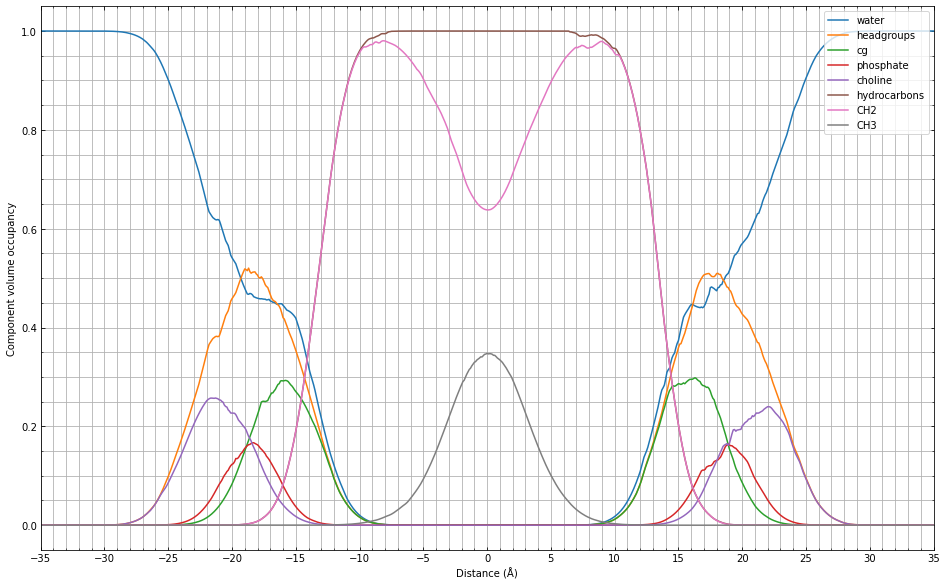

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(
    store + "/bilayerplotdata.dat", sep="\s", engine="python"
)

# use methyl groups to align plot
methyls = bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"]
center = np.argmax(methyls) * stepsize
zax = bilayer_plot_data["zaxis"] -center

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")
ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

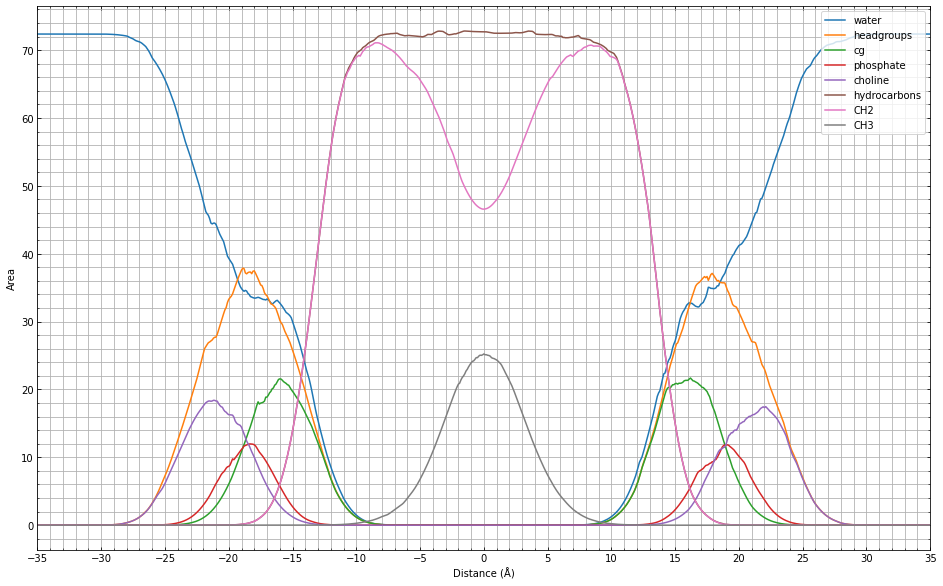

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(
    store + "/bilayerplotdata.dat", sep="\s", engine="python"
)

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr"] + bilayer_plot_data["outerhg_corr"], label="headgroups")
ax.plot(zax, bilayer_plot_data["inner_cg_corr"] + bilayer_plot_data["outer_cg_corr"],label="cg")
ax.plot(zax, bilayer_plot_data["inner_phosphate_corr"] + bilayer_plot_data["outer_phosphate_corr"], label="phosphate")
ax.plot(zax, bilayer_plot_data["inner_choline_corr"] + bilayer_plot_data["outer_choline_corr"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr"]+bilayer_plot_data["outerhc_corr"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr"]+bilayer_plot_data["outerch2_corr"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr"]+bilayer_plot_data["outerch3_corr"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/area", facecolor="white")
plt.show()


# Diagnostics

Simulation number density times electron number:
choline:  49.98850759999983
phosphate:  46.98311119999985
cg:  58.9887687999998
hc:  269.94463079999906
methyl:  17.99429599999994
water:  309.490234799999


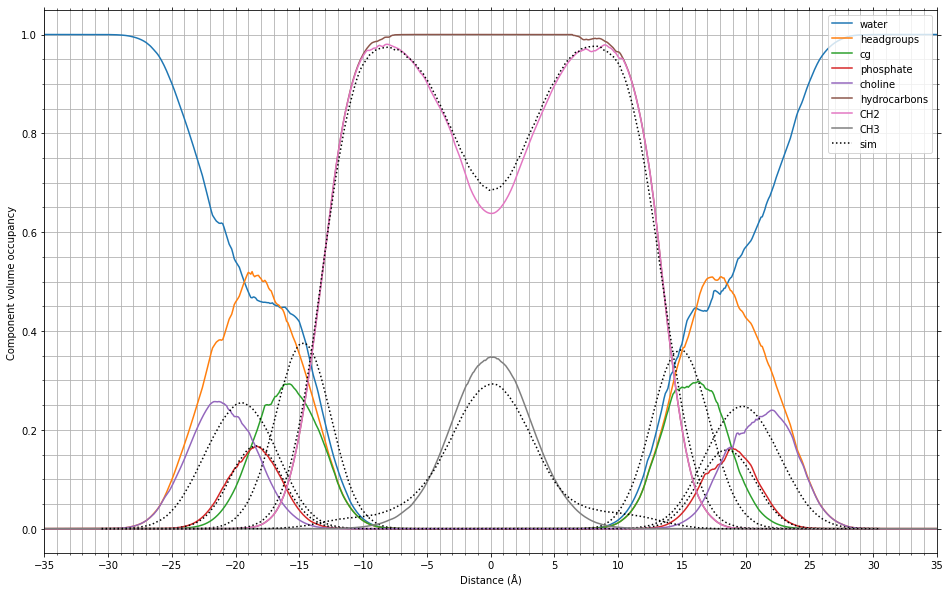

Fit:
choline:  123.9921715737753
phosphate:  61.417438383860514
cg:  137.48439959354928
hc:  966.1713772039964
methyl:  100.27251792754585
Simulation, volume weighted electron densities:
choline:  127.07078631919954
phosphate:  63.19728276731893
cg:  148.57171260474527
hc:  978.8949466307904
methyl:  100.86802591111078


In [28]:
# Create an electron density profile from the sim data and, in a second step
# divide it by the electron densities per molecular group used in the fit
# this creates a volume-correct plot of the electron densities.


simdata = pd.read_csv('../dopc72.4bcut.sim', sep="\s+", comment='#')
#print(simdata)

columnlist = list(simdata)
for element in columnlist:
    if element[0] == 'o':
        simdata[element]=simdata[element].multiply(8.)
    if element[0] == 'h':
        simdata[element]=simdata[element].multiply(1.)
    if element[0] == 'd':
        simdata[element]=simdata[element].multiply(1.)
    if element[0] == 'n':
        simdata[element]=simdata[element].multiply(7.)
    if element[0] == 'p':
        simdata[element]=simdata[element].multiply(15.)
    if element[0] == 'c':
        simdata[element]=simdata[element].multiply(6.)


ph_str = "ph op1h op2h op3h op4h"
ph_col = ph_str.split()
cg_str = "c1c1 o1c1 c1h h1ah h1bh c1c2 o1c2 o2h c2h h2ah c3h h3ah h3bh" #o1h missing
cg_col = cg_str.split()
chol_str = "c6h h6ah h6bh h6ch c7h h7ah h7bh h7ch c8h h8ah h8bh h8ch c4h h4ah h4bh c5h h5ah h5bh nh"
chol_col = chol_str.split()
ch2_str = "c2c1 h2ac1 h2bc1 c3c1 h3ac1 h3bc1 c4c1 h4ac1 h4bc1 c5c1 h5ac1 h5bc1 c6c1 h6ac1 h6bc1 c7c1 h7ac1 h7bc1 c8c1 h8ac1 h8bc1 c11c1 h11ac1 h11bc1 c12c1 h12ac1 h12bc1 c13c1 h13ac1 h13bc1 c14c1 h14ac1 h14bc1 c15c1 h15ac1 h15bc1 c16c1 h16ac1 h16bc1 c17c1 h17ac1 h17bc1 c2c2 h2ac2 h2bc2 c3c2 h3ac2 h3bc2 c4c2 h4ac2 h4bc2 c5c2 h5ac2 h5bc2 c6c2 h6ac2 h6bc2 c7c2 h7ac2 h7bc2 c8c2 h8ac2 h8bc2 c11c2 h11ac2 h11bc2 c12c2 h12ac2 h12bc2 c13c2 h13ac2 h13bc2 c14c2 h14ac2 h14bc2 c15c2 h15ac2 h15bc2 c16c2 h16ac2 h16bc2 c17c2 h17ac2 h17bc2 c9c1 c10c1 h9ac1 h10ac1 c9c2 c10c2 h9ac2 h10ac2"
ch2_col = ch2_str.split()
ch3_str = "c18c1 h18ac1 h18bc1 h18cc1 c18c2 h18ac2 h18bc2 h18cc2"
ch3_col = ch3_str.split()
h2o_str = "ow d1w d2w"
h2o_col = h2o_str.split()

ph_sim=simdata[ph_col].sum(axis=1).to_numpy()
cg_sim=simdata[cg_col].sum(axis=1).to_numpy()
chol_sim=simdata[chol_col].sum(axis=1).to_numpy()
ch2_sim=simdata[ch2_col].sum(axis=1).to_numpy()
ch3_sim=simdata[ch3_col].sum(axis=1).to_numpy()
h2o_sim=simdata[h2o_col].sum(axis=1).to_numpy()
z_sim = simdata["Zbin"].to_numpy()

stepsize_sim = z_sim[1]-z_sim[0]
print("Simulation number density times electron number:")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("water: ",h2o_sim.sum()*stepsize_sim*areaperlipid_sim/2)

# edensity 
ed_total = (ph_sim+cg_sim+chol_sim+ch2_sim+ch3_sim+h2o_sim)
ed_mf = ph_sim+cg_sim+chol_sim+ch2_sim+ch3_sim

normfactor=1.0
ph_sim*=normfactor/(47/v_phosphate_fit)
cg_sim*=normfactor/((67-8)/(v_cg_fit))      #should be (67, 147), but one O is missing
chol_sim*=normfactor/(50/v_choline_fit)
ch2_sim*=normfactor/(252/(va1_fit-vm1_fit))
ch3_sim*=normfactor/(18/vm1_fit)

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")

ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(z_sim, cg_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(z_sim, ph_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(z_sim, chol_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")

ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(z_sim, ch2_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.plot(z_sim, ch3_sim, linestyle='dotted', color='black', label="sim")

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
#ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo_sldweighted", facecolor="white")
plt.show()

stepsize_z=zax[1]-zax[0]
print("Fit:")
print("choline: ",bilayer_plot_data["inner_choline_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("phosphate: ",bilayer_plot_data["inner_phosphate_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("cg: ",bilayer_plot_data["inner_cg_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("hc: ",bilayer_plot_data["innerhc_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("methyl: ",bilayer_plot_data["innerch3_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("Simulation, volume weighted electron densities:")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)


Number of electrons (half bilayer):
choline:  18.99623959999993
phosphate:  4.998278799999984
cg:  12.997320399999955
hc:  99.97947679999966
methyl:  7.998389999999973


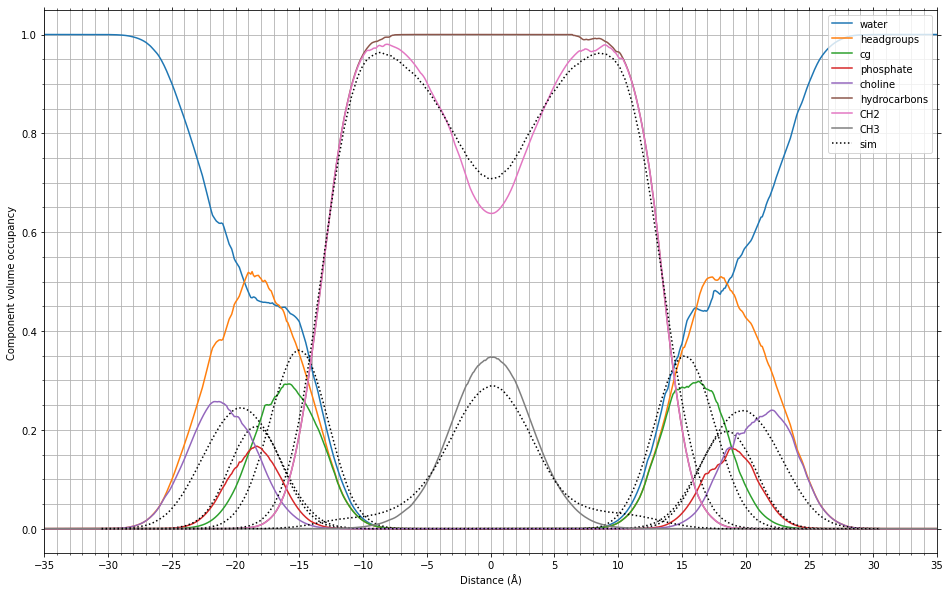

Fit:
choline:  123.9921715737753
phosphate:  61.417438383860514
cg:  137.48439959354928
hc:  966.1713772039964
methyl:  100.27251792754585
Simulation, volume weighted electron densities:
choline:  127.07484490315746
phosphate:  78.99779643399972
cg:  148.56937011076874
hc:  978.8991550463011
methyl:  100.87969387499966


In [29]:
# Create an volume density plot using VDW radii

simdata = pd.read_csv('../dopc72.4bcut.sim', sep="\s+", comment='#')
#print(simdata)

columnlist = list(simdata)
#for element in columnlist:
#    if element[0] == 'o':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.6)**3)
#    if element[0] == 'h':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.2)**3)
#    if element[0] == 'n':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.7)**3)
#    if element[0] == 'p':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.8)**3)
#    if element[0] == 'c':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.9)**3)


ph_str = "ph op1h op2h op3h op4h"
ph_col = ph_str.split()
cg_str = "c1c1 o1c1 c1h h1ah h1bh c1c2 o1c2 o2h c2h h2ah c3h h3ah h3bh" #o1h missing
cg_col = cg_str.split()
chol_str = "c6h h6ah h6bh h6ch c7h h7ah h7bh h7ch c8h h8ah h8bh h8ch c4h h4ah h4bh c5h h5ah h5bh nh"
chol_col = chol_str.split()
ch2_str = "c2c1 h2ac1 h2bc1 c3c1 h3ac1 h3bc1 c4c1 h4ac1 h4bc1 c5c1 h5ac1 h5bc1 c6c1 h6ac1 h6bc1 c7c1 h7ac1 h7bc1 c8c1 h8ac1 h8bc1 c11c1 h11ac1 h11bc1 c12c1 h12ac1 h12bc1 c13c1 h13ac1 h13bc1 c14c1 h14ac1 h14bc1 c15c1 h15ac1 h15bc1 c16c1 h16ac1 h16bc1 c17c1 h17ac1 h17bc1 c2c2 h2ac2 h2bc2 c3c2 h3ac2 h3bc2 c4c2 h4ac2 h4bc2 c5c2 h5ac2 h5bc2 c6c2 h6ac2 h6bc2 c7c2 h7ac2 h7bc2 c8c2 h8ac2 h8bc2 c11c2 h11ac2 h11bc2 c12c2 h12ac2 h12bc2 c13c2 h13ac2 h13bc2 c14c2 h14ac2 h14bc2 c15c2 h15ac2 h15bc2 c16c2 h16ac2 h16bc2 c17c2 h17ac2 h17bc2 c9c1 c10c1 h9ac1 h10ac1 c9c2 c10c2 h9ac2 h10ac2"
ch2_col = ch2_str.split()
ch3_str = "c18c1 h18ac1 h18bc1 h18cc1 c18c2 h18ac2 h18bc2 h18cc2"
ch3_col = ch3_str.split()

ph_sim=simdata[ph_col].sum(axis=1).to_numpy()
cg_sim=simdata[cg_col].sum(axis=1).to_numpy()
chol_sim=simdata[chol_col].sum(axis=1).to_numpy()
ch2_sim=simdata[ch2_col].sum(axis=1).to_numpy()
ch3_sim=simdata[ch3_col].sum(axis=1).to_numpy()
z_sim = simdata["Zbin"].to_numpy()

stepsize_sim = z_sim[1]-z_sim[0]
print("Number of electrons (half bilayer):")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)

normfactor=1.0
ph_sim*=normfactor/4*(v_phosphate_fit)
cg_sim*=normfactor/(14-1)*(v_cg_fit)   #should be (14,147), but one O is missing      
chol_sim*=normfactor/19*(v_choline_fit)
ch2_sim*=normfactor/92*(va1_fit-vm1_fit)
ch3_sim*=normfactor/8*vm1_fit

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")

ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(z_sim, cg_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(z_sim, ph_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(z_sim, chol_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")

ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(z_sim, ch2_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.plot(z_sim, ch3_sim, linestyle='dotted', color='black', label='sim')

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
#ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo_atomdensityweighted", facecolor="white")
plt.show()

print("Fit:")
print("choline: ",bilayer_plot_data["inner_choline_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("phosphate: ",bilayer_plot_data["inner_phosphate_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("cg: ",bilayer_plot_data["inner_cg_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("hc: ",bilayer_plot_data["innerhc_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("methyl: ",bilayer_plot_data["innerch3_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("Simulation, volume weighted electron densities:")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)


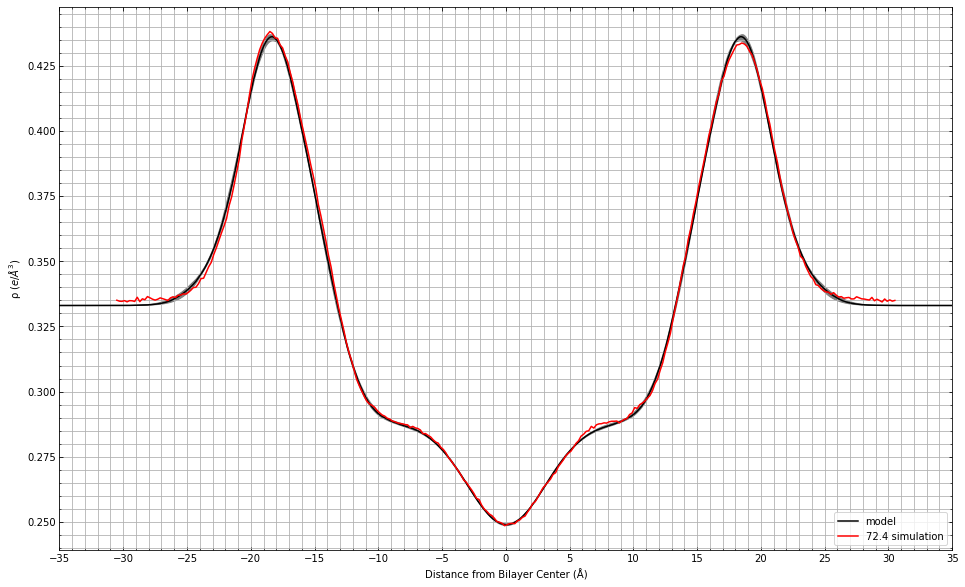

In [30]:
#feller = np.loadtxt("FellerDOPCSimedp.dat")


a = fit_analysis.diStatResults["nSLDProfiles"]
b = []
for i in range(len(a)):
    it = a[i][0][0]
    it = [(it[n] + bulknsld_fit) / 2.814e-5 for n in range(len(it))]
    b += [it]

b = np.array(b).T
c = []
for i in range(len(b)):
    cc = fit_analysis.fnCalcConfidenceLimits(b[i])
    c += [cc]
c = np.array(c).T
z = [stepsize * (i - np.argmin(c[2])) for i in range(dimension)]

plt.figure(figsize=(16, 10))
plt.fill_between(z, c[3], y2=c[1], color="grey")
plt.xlabel("Distance from Bilayer Center (Å)")
plt.ylabel("ρ $(e/Å^3)$")
plt.plot(z, c[2], color="black", label="model")
#plt.plot(feller[:, 0], feller[:, 1], color="red", label="feller")
plt.plot(z_sim, ed_total, color="red", label="72.4 simulation")
plt.minorticks_on()
plt.tick_params(which="both", direction="in", labelsize=10)
plt.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.legend(loc="lower right")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
plt.savefig(store + "/electron_density", facecolor="white")
plt.show()


## Solvent-subtracted electron density profile

Stepsizes:
fit:  0.09999999999999432 0.09999999999999432
SDP:  0.1999999999999993 0.1999999999999993
Integral (half): 
fit:  -0.03687956675808506
SDP:  -0.10139399999999837
FO from DCT-definition (half profile):
fit:  0.06536560848914762
SDP:  0.20278799999999675
F0 estimate (half profile):
fit:  0.07375913351617013
SDP:  0.20278799999999675


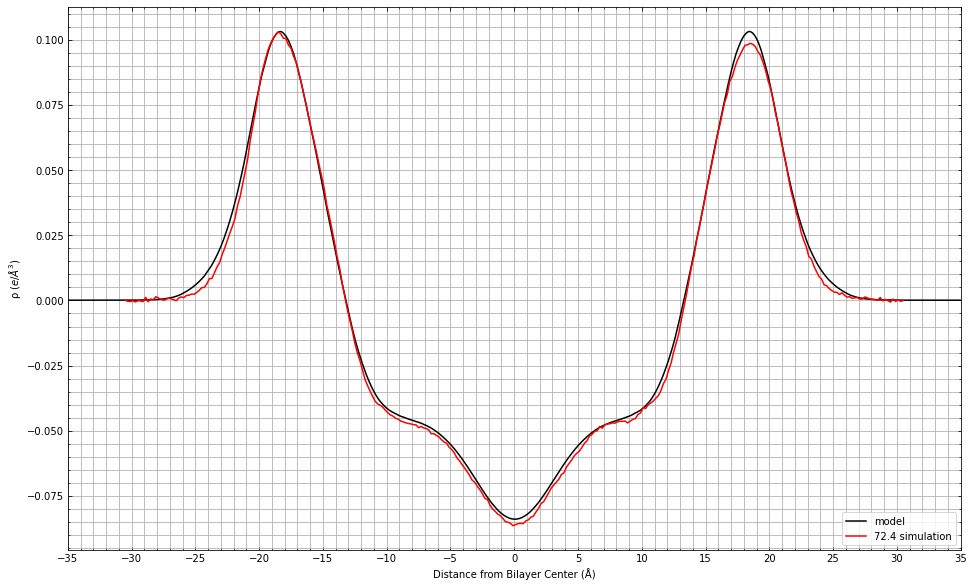

In [31]:
fit_ed_minus_fluid = c[2]-bulknsld_fit/ed2sld
sdp_ed_minus_fluid = ed_total-9.4269e-6/ed2sld

sum_fit = fit_ed_minus_fluid.sum()
sum_sdp = sdp_ed_minus_fluid.sum()
half_fit_ed_minus_fluid = fit_ed_minus_fluid[int(len(fit_ed_minus_fluid)/2) :]
half_sdp_ed_minus_fluid = sdp_ed_minus_fluid[int(len(sdp_ed_minus_fluid)/2) :]
half_sum_fit = half_fit_ed_minus_fluid.sum()
half_sum_sdp = half_sdp_ed_minus_fluid.sum()

print("Stepsizes:")
print("fit: ", stepsize_z, z[1] - z[0])
print("SDP: ", stepsize_sim, z_sim[1] - z_sim[0])

print("Integral (half): ")
print("fit: ", half_sum_fit * stepsize_z)
print("SDP: ", half_sum_sdp * stepsize_sim)
#print("SDP_mf", half_sum_spd_mf * stepsize_sim)

print("FO from DCT-definition (half profile):")
print("fit: ", np.abs((2 * half_sum_fit - half_fit_ed_minus_fluid[0])* stepsize_z))
print("SDP: ", np.abs((2 * half_sum_sdp) * stepsize_sim))

print("F0 estimate (half profile):")
print("fit: ", np.abs(half_sum_fit * stepsize_z)*2)
print("SDP: ", np.abs(half_sum_sdp * stepsize_sim)*2)

plt.figure(figsize=(16, 10))
plt.xlabel("Distance from Bilayer Center (Å)")
plt.ylabel("ρ $(e/Å^3)$")
plt.plot(z, fit_ed_minus_fluid, color="black", label="model")
#plt.plot(z[int(len(z)/2):], half_fit_ed_minus_fluid+0.02, color="black", label="1/2 model + 0.02")
#plt.plot(feller[:, 0], feller[:, 1], color="red", label="feller")
plt.plot(z_sim, sdp_ed_minus_fluid, color="red", label="72.4 simulation")
#plt.plot(z_sim, ed_mf, label="72.4 simulation mf")
#plt.plot(z_sim[int(len(z_sim)/2):], half_sdp_ed_minus_fluid+0.02, color="red", label="1/2 72.4 simulation + 0.02")
plt.minorticks_on()
plt.tick_params(which="both", direction="in", labelsize=10)
plt.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.legend(loc="lower right")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
plt.savefig(store + "/electron_density_fluid_subtracted", facecolor="white")
plt.show()


In [32]:
Afterfit_FF = computeFormFactor(q, fit_ed_minus_fluid, prefactor_fit, dq_fit, 0, z[1] - z[0])
SDP_FF = computeFormFactor(q, sdp_ed_minus_fluid, 1, dq_fit, 0, z_sim[1] - z_sim[0], DCTtype=2)

1.6216529859390918


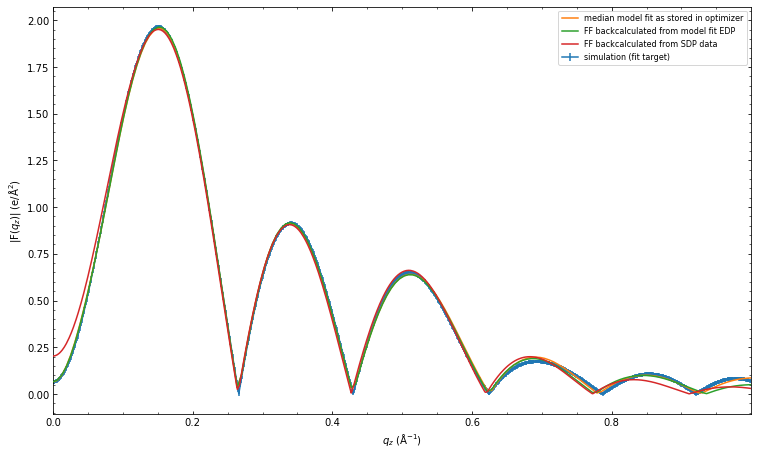

In [33]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq())

q, F, dq, Fy = np.loadtxt(store + "/" + runfile + ".dat", skiprows=1).T
fig, ax = plt.subplots()
ax.errorbar(q, F, dq, zorder=1, label="simulation (fit target)")
ax.plot(q, Fy, zorder=2, label="median model fit as stored in optimizer")
ax.plot(q, Afterfit_FF, zorder=3, label="FF backcalculated from model fit EDP")
ax.plot(q, SDP_FF, zorder=4, label="FF backcalculated from SDP data")

ax.legend(fontsize=8)
ax.set_xlim([q[0], q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()


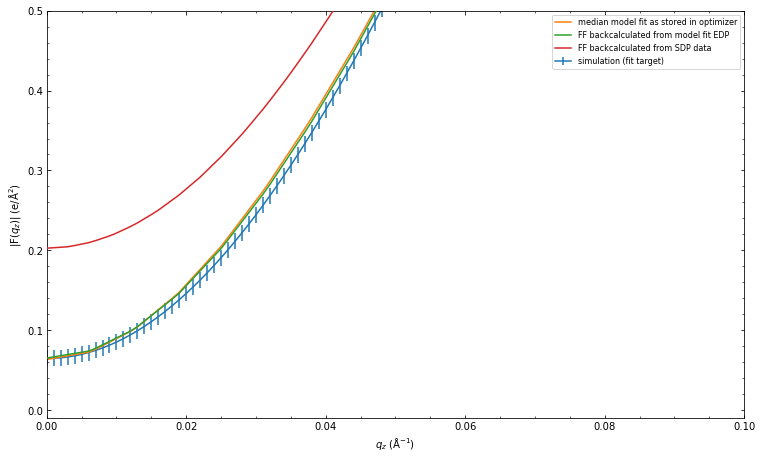

In [34]:
fig, ax = plt.subplots()
ax.errorbar(q, F, dq, zorder=1, label="simulation (fit target)")
ax.plot(q, Fy, zorder=2, label="median model fit as stored in optimizer")
ax.plot(q, Afterfit_FF, zorder=3, label="FF backcalculated from model fit EDP")
ax.plot(q, SDP_FF, zorder=4, label="FF backcalculated from SDP data")

ax.legend(fontsize=8)
ax.set_xlim([q[0], q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
plt.xlim(0.0, 0.1)
plt.ylim(-0.01, 0.5)
plt.savefig(store + "/model_comparison_zoom.png", facecolor="white")
plt.show()